In [29]:
import os
import shutil
import csv

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

import pandas as pd

%matplotlib inline

from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

In [13]:
# import helpers
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

TODO: davidtan [2017-08-25]
- include cells of shell scripts for data preprocessing - e.g. from zip file to organized folders in data/
- visualize model on TensorBoard
- clean up the TensorFlow imports that are not used

Typical process of training/evaluating/optimizing a model:
- data preprocessing

- loading pretrained network
- training and evaluating


### Data preprocessing

In [2]:
labels_df = pd.read_csv('./data/train_labels.csv')

In [3]:
labels_df.head()

,name,invasive
0,1,0
1,2,0
2,3,1
3,4,0
4,5,1


In [5]:
# Move files to invasive/ and non_invasive/ folders
import os
import shutil
import csv

dir_src = './data/train/'
invasive_destination = './data/train/invasive/' 
non_invasive_destination = './data/train/non_invasive/' 

with open('./data/train_labels.csv', 'r') as f:
    reader = csv.reader(f, delimiter = ',')
    for rowDict in reader:
        filename, label = rowDict
        src_file = os.path.join(dir_src, "{}{}".format(filename, '.jpg'))
        if os.path.exists(src_file):
            if label == '1':
                shutil.move(src_file, invasive_destination)
            elif label == '0':
                shutil.move(src_file, non_invasive_destination)

In [34]:
import utils; reload(utils)
from utils import *

# to see what it is in utils, run `%load utils.py`

In [7]:
# As large as you can, but no larger than 64 is recommended. 
# If you have an older or cheaper GPU, you'll run out of memory, so will have to decrease this.
batch_size=64

# Import our class, and instantiate
import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [8]:
path = "./data/"

vgg = Vgg16()
# Grab a few images at a time for training and validation.
# NB: They must be in subdirectories named based on their category
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch=1)

Found 2184 images belonging to 2 classes.
Found 111 images belonging to 2 classes.
Epoch 1/1
2184/2184 [==============================] - 103s - loss: 0.5423 - acc: 0.8100 - val_loss: 0.3100 - val_acc: 0.8739


In [9]:
vgg.fit(batches, val_batches, nb_epoch=3)

Epoch 1/3
2184/2184 [==============================] - 91s - loss: 0.3756 - acc: 0.8658 - val_loss: 0.2788 - val_acc: 0.9009
Epoch 2/3
2184/2184 [==============================] - 85s - loss: 0.3259 - acc: 0.8713 - val_loss: 0.2285 - val_acc: 0.9099
Epoch 3/3
2184/2184 [==============================] - 84s - loss: 0.3145 - acc: 0.8695 - val_loss: 0.1980 - val_acc: 0.9279


# Iteration 2: Intentionally overfitting

We're going to be training a number of iterations without dropout, so it would be best for us to pre-calculate the input to the fully connected layers - i.e. the Flatten() layer. We'll start by finding this layer in our model, and creating a new model that contains just the layers up to and including this layer:

In [94]:
import vgg16; reload(vgg16)
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model


path = "./data/"
model_path = path + "models/"
if not os.path.exists(model_path): os.mkdir(model_path)

In [53]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_6 (Lambda)                (None, 3, 224, 224)   0           lambda_input_6[0][0]             
____________________________________________________________________________________________________
zeropadding2d_66 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_6[0][0]                   
____________________________________________________________________________________________________
convolution2d_66 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_66[0][0]           
____________________________________________________________________________________________________
zeropadding2d_67 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_66[0][0]           
___________________________________________________________________________________________

In [95]:
model.pop()
for layer in vgg.model.layers: layer.trainable=False

In [96]:
model.add(Dense(2, activation='softmax'))

In [97]:
layers = model.layers


In [98]:
last_conv_idx = [index for index,layer in enumerate(layers) 
                     if type(layer) is Convolution2D][-1]

layers[last_conv_idx]

In [99]:
conv_layers = layers[:last_conv_idx+1]
conv_model = Sequential(conv_layers)
# Dense layers - also known as fully connected or 'FC' layers
fc_layers = layers[last_conv_idx+1:]

In [100]:
batches = get_batches(path+'train', shuffle=False, batch_size=batch_size)
val_batches = get_batches(path+'valid', shuffle=False, batch_size=batch_size)

val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

Found 2184 images belonging to 2 classes.
Found 111 images belonging to 2 classes.


In [101]:
batches.class_indices

{'invasive': 0, 'non_invasive': 1}

In [102]:
val_features = conv_model.predict_generator(val_batches, val_batches.nb_sample)

In [103]:
trn_features = conv_model.predict_generator(batches, batches.nb_sample)

In [104]:
save_array(model_path + 'train_convlayer_features.bc', trn_features)
save_array(model_path + 'valid_convlayer_features.bc', val_features)

In [105]:
trn_features.shape

(2184, 512, 14, 14)

In [106]:
# Copy the weights from the pre-trained model.
# NB: Since we're removing dropout, we want to half the weights
def proc_wgts(layer): return [o/2 for o in layer.get_weights()]

In [107]:
# Such a finely tuned model needs to be updated very slowly!
opt = RMSprop(lr=0.00001, rho=0.7)

In [108]:
def get_fc_model():
    model = Sequential([
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.),
        Dense(4096, activation='relu'),
        Dropout(0.),
        Dense(2, activation='softmax')
        ])

    for l1,l2 in zip(model.layers, fc_layers): l1.set_weights(proc_wgts(l2))

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [109]:
fc_model = get_fc_model()

In [110]:
fc_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
maxpooling2d_41 (MaxPooling2D)   (None, 512, 7, 7)     0           maxpooling2d_input_6[0][0]       
____________________________________________________________________________________________________
flatten_13 (Flatten)             (None, 25088)         0           maxpooling2d_41[0][0]            
____________________________________________________________________________________________________
dense_40 (Dense)                 (None, 4096)          102764544   flatten_13[0][0]                 
____________________________________________________________________________________________________
dropout_25 (Dropout)             (None, 4096)          0           dense_40[0][0]                   
___________________________________________________________________________________________

In [111]:
fc_model.fit(trn_features, trn_labels, nb_epoch=8, 
             batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 2184 samples, validate on 111 samples
Epoch 1/8
2184/2184 [==============================] - 3s - loss: 0.2970 - acc: 0.8640 - val_loss: 0.1958 - val_acc: 0.9189
Epoch 2/8
2184/2184 [==============================] - 3s - loss: 0.1520 - acc: 0.9396 - val_loss: 0.1835 - val_acc: 0.9279
Epoch 3/8
2184/2184 [==============================] - 3s - loss: 0.0907 - acc: 0.9647 - val_loss: 0.2966 - val_acc: 0.9009
Epoch 4/8
2184/2184 [==============================] - 3s - loss: 0.0585 - acc: 0.9803 - val_loss: 0.2056 - val_acc: 0.9369
Epoch 5/8
2184/2184 [==============================] - 3s - loss: 0.0274 - acc: 0.9922 - val_loss: 0.2204 - val_acc: 0.9369
Epoch 6/8
2184/2184 [==============================] - 3s - loss: 0.0136 - acc: 0.9959 - val_loss: 0.2690 - val_acc: 0.9189
Epoch 7/8
2184/2184 [==============================] - 3s - loss: 0.0062 - acc: 0.9991 - val_loss: 0.3325 - val_acc: 0.9279
Epoch 8/8
2184/2184 [==============================] - 3s - loss: 0.0020 - acc: 0.999

# Regularization

# Iteration 3: Data augmentation

In [113]:
# dim_ordering='tf' uses tensorflow dimension ordering,
#   which is the same order as matplotlib uses for display.
# Therefore when just using for display purposes, this is more convenient
gen = image.ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
       height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
       channel_shift_range=10., horizontal_flip=True, dim_ordering='tf')

In [82]:
image.ImageDataGenerator?

In [78]:
# Create a 'batch' of a single image
img = np.expand_dims(ndimage.imread('data/test/1.jpg'),0)
# Request the generator to create batches from this image
aug_iter = gen.flow(img)

In [79]:
# Get eight examples of these augmented images
aug_imgs = [next(aug_iter)[0].astype(np.uint8) for i in range(8)]

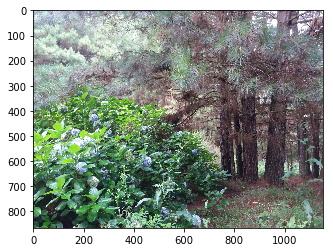

In [80]:
# The original
plt.imshow(img[0])

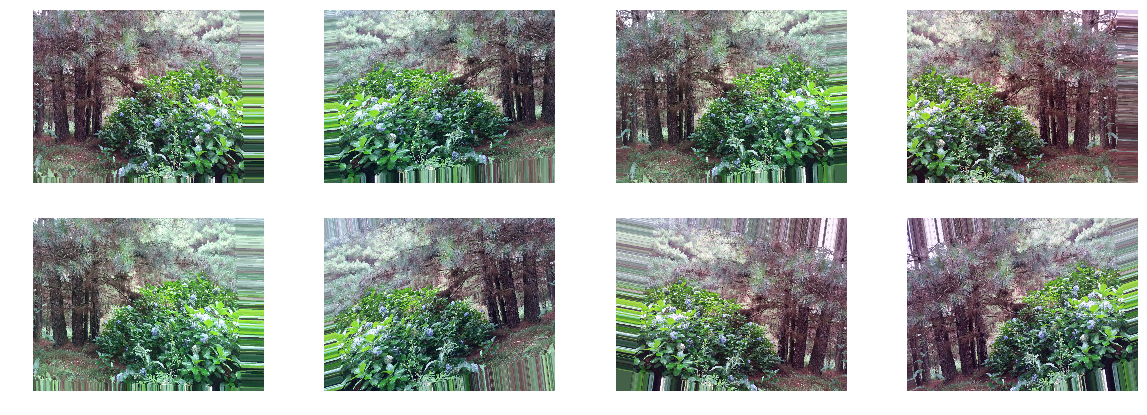

In [81]:
# Augmented data
plots(aug_imgs, (20,7), 2)

In [83]:
# Ensure that we return to theano dimension ordering
K.set_image_dim_ordering('th')

### Add data augmentation

In [114]:
gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, 
                               height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)

In [115]:
batches = get_batches(path+'train', gen, batch_size=batch_size)
# NB: We don't want to augment or shuffle the validation set
val_batches = get_batches(path+'valid', shuffle=False, batch_size=batch_size)

Found 2184 images belonging to 2 classes.
Found 111 images belonging to 2 classes.


In [116]:
fc_model = get_fc_model()

In [117]:
for layer in conv_model.layers: layer.trainable = False
# Look how easy it is to connect two models together!
conv_model.add(fc_model)

In [118]:
conv_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [119]:
conv_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=8, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/8
1472/2184 [===================>..........] - ETA: 28s - loss: 0.3779 - acc: 0.8308

KeyboardInterrupt: 